In [1]:
import tensorflow as tf
import json
import munch
import sde as eqn
import options as opts
from pricers import EarlyExercisePricer, MarkovianPricer
from generate_data import create_dataset

# load config
sde_list = ["GBM", "TGBM", "SV", "SVJ", "HW"]
option_list = [
    "European",
    "EuropeanPut",
    "Lookback",
    "Asian",
    "Basket",
    "BasketnoPI",
    "Swap",
    "Bond",
    "Swaption",
    "TimeEuropean",
    "BermudanPut",
]
dim_list = [1, 3, 5, 10, 20]

sde_name = "HW"
option_name = "Swaption"
dim = 1

if (
    (sde_name not in sde_list)
    or (option_name not in option_list)
    or (dim not in dim_list)
):
    raise ValueError(
        f"please input right sde_name in {sde_list},\
                          option_name in {option_list} and dim in {dim_list}"
    )
else:
    json_path = f"./configs/{sde_name}_{option_name}_{dim}.json"
with open(json_path) as json_data_file:
    config = json.load(json_data_file)

config = munch.munchify(config)
initial_mode = config.eqn_config.initial_mode
kernel_type = config.net_config.kernel_type
sde = getattr(eqn, config.eqn_config.sde_name)(config)
option = getattr(opts, config.eqn_config.option_name)(config)

samples = config.eqn_config.sample_size
time_steps = config.eqn_config.time_steps
dims = config.eqn_config.dim
dataset_path = f"./dataset/{sde_name}_{option_name}_{dim}_{time_steps}"
create_dataset(sde_name, option_name, dim, 50)

# load dataset
dataset = tf.data.experimental.load(
    dataset_path,
    element_spec=(
        tf.TensorSpec(shape=(samples, time_steps + 1, 1)),
        tf.TensorSpec(shape=(samples, time_steps + 1, dims)),
        tf.TensorSpec(shape=(samples, time_steps, dims)),
        tf.TensorSpec(shape=(samples, time_steps + 1, 4)),
    ),
)
dataset = dataset.batch(config.eqn_config.batch_size)
def slice_fn(t, x, dw, u):
    t_slice = t[:, :, 10:, :]
    x_slice = x[:, :, 10:, :]
    dw_slice = dw[:, :, 10:, :]
    u_slice = u[:, :, 10:, :]
    return t_slice, x_slice, dw_slice, u_slice
sub_dataset = dataset.map(slice_fn)
test_dataset = sub_dataset.take(10)
train_dataset = sub_dataset.skip(10)
checkpoint_path = f"./checkpoint2/HW_bermudan/{sde_name}_{option_name}_{dim}_2"
# initialize the solver and train
pricer = MarkovianPricer(sde, option, config)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=config.net_config.lr, decay_steps=2000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-6)
pricer.compile(optimizer=optimizer)
# tf.config.run_functions_eagerly(True)
pricer.fit(x=dataset, epochs=20)
pricer.no_net.save_weights(checkpoint_path)



2023-10-30 17:50:19.629641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.
(TensorSpec(shape=(50, 21, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 21, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 20, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 21, 4), dtype=tf.float32, name=None))
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
Epoch 1/20
50/50 [==============================] - 20s 143ms/step - loss: 0.0181 - loss interior: 0.0172 - loss terminal: 9.2951e-04
Epoch 2/20
50/50 [==============================] - 8s 163ms/step - loss: 0.0111 - loss interior: 0.0105 - loss terminal: 6.0679e-04
Epoch 3/20
50/50 [==============================] - 8s 156ms/step - loss: 0.0098 - loss interior: 0.0093 - loss terminal: 5.5639e-04
Epoch 4/20
50/50 [==============================] - 8s 158ms/step - loss: 0.0039 - loss interior: 0.0036 - loss terminal: 2.4868e-04
Epoch 5/20
50/50 [==============================] - 19s 375ms/step - loss: 8.2366e-04 - lo

In [11]:
for element in test_dataset.take(5):
    t, x, _, u = element
t0, x0, u0 = t,x,u
y_pred = pricer((t0, x0, u0))
y_exact = option.zcp(t0, x0, u0, 1) - option.zcp(t0, x0, u0, 3)
# t, x, u = t[:, :, 11:, :], x[:, :, 11:, :], u[:, :, 11:, :]
# y_pred_1 = pricer.no_nets[1]((t1, x1, u1))
# y_exact_1 = option.zcp(t1, x1, u1, 2) - option.zcp(t1, x1, u1, 3)
# y_pred, y_exact = tf.concat([y_pred_0, y_pred_1], axis=2), tf.concat([y_exact_0, y_exact_1], axis=2)
y_pred, y_exact, t = y_pred.numpy(), y_exact.numpy(), t.numpy()

# print(pricer.no_nets)

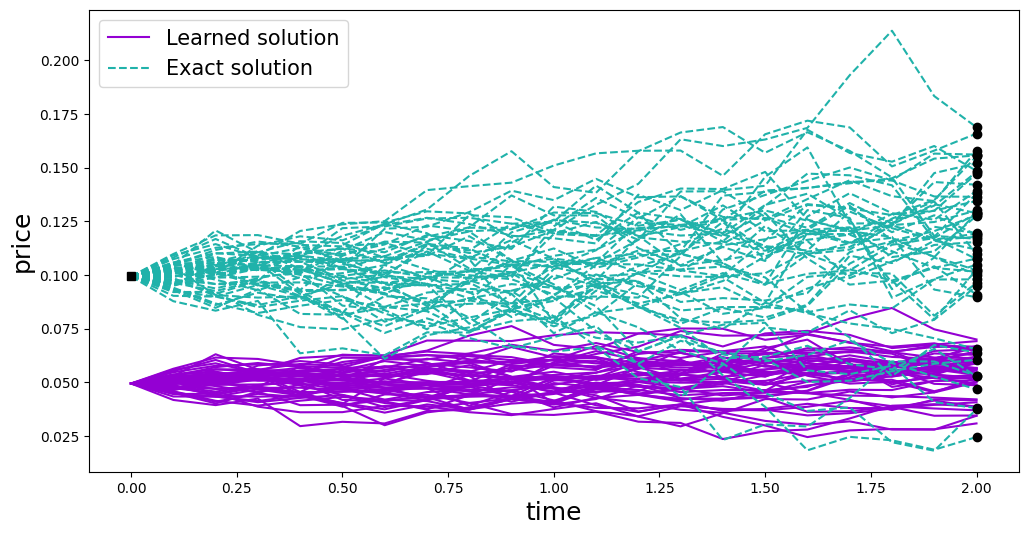

AttributeError: EagerTensor object has no attribute 'T'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [12]:
import matplotlib.pyplot as plt
def plot_mc_curves(y_pred, y_true, t_test, x_mc, u_hat):
    samples = 50
    plt.figure(figsize=(12, 6))
    plt.plot(t_test[0:1,:].T, y_pred[0:1,:].T,'darkviolet',label='Learned solution')
    plt.plot(t_test[0:1,:].T, y_true[0:1,:].T,'--',color='lightseagreen',label='Exact solution')
    plt.plot(t_test[0:1,-1], y_true[0:1,-1],'ko') #,label='$Y_T = u(T,X_T)$')

    plt.plot(t_test[1:samples,:].T, y_pred[1:samples,:].T,'darkviolet')
    plt.plot(t_test[1:samples,:].T, y_true[1:samples,:].T,'--',color='lightseagreen')
    plt.plot(t_test[1:samples,-1], y_true[1:samples,-1],'ko')

    plt.plot([0],y_true[0,0],'ks') # ,label='$Y_0 = u(0,X_0)$')

    plt.xlabel('time', fontdict={"size": 18})
    plt.ylabel('price', fontdict={"size": 18})
    #plt.title(fr'm={u_hat[-1]: 2f}, r={u_hat[0]: 2f}, $\theta$={u_hat[1]: 2f},$\kappa$={u_hat[2]: 2f}， $\sigma$={u_hat[3]: 2f}, $\rho$={u_hat[4]: 2f}')# , $\rho$={u_hat[2]: 2f}')
    plt.legend(prop={"size": 15})
    plt.show()
    plt.plot(t_test[1:samples,:].T, x_mc[1:samples, :, 0].T,'g',label='$X_t$')
idx_1 = 0
idx = 10
plot_mc_curves(y_pred[idx, :, :, 0], y_exact[idx, :, :, 0], t[idx, :, :, 0], x[idx], u[idx])

